In [1]:
!pip install pandas

In [59]:
import os
from pyspark import SparkContext
from pyspark.sql import SparkSession
import findspark
import numpy as np
import pyspark
import pandas as pd
findspark.init()

In [6]:
mnist_dataset = serialReadFile('mnist_dataset.csv')
X = mnist_dataset.iloc[:, 1:]
y = mnist_dataset.iloc[:, 0]

print(X.shape)
print(len(y))
# so each centroid will be a tuple of 785 coordinates like this (0,1,0.5, ... , 2.5)

(70000, 784)
70000


In [4]:
# serial k-means from scratch

def serialReadFile(filename):
    current_directory = os.getcwd()
    data = pd.read_csv(current_directory + "/" + filename)
    return data

def serialAssign2cluster(x, centroids):
    
    ''' centroids = [(785 elements), (785 elements), ... ], 
    x = (785 elements)
    
    return: index of the closest cluster
    '''
    # how do i compute the distance between one element and the centroids?
    
    distances = [np.sqrt(np.sum((np.array(x) - np.array(c))**2)) for c in centroids]
    index = int(np.argmin(distances))
        
    return index

def serialKMeans(X, K, n_iter):
    
    ''' X is a pandas dataframe
    K number of clusters for grouping
    n_iter int

    return: labels updated
    '''
    X_array = X.values #using numpy for efficiency

    # centroids initialization
    centroids = [tuple(np.random.randn(X.shape[1])) for i in range(K)]
    labels = np.zeros(X.shape[0], dtype=int)

    for iteration in range(n_iter):
    
        for i in range(X.shape[0]):
            # assign each point to the closest cluster
            labels[i] = serialAssign2cluster(X_array[i], centroids)
    
        # updating the centroids coordinates
        new_centroids = np.zeros_like(centroids)
        for k in range(K):
            
            # points belonging to cluster k
            cluster_points = X_array[labels == k]
            if len(cluster_points) > 0:
                # mean along rows -> centroid coords
                new_centroids[k] = cluster_points.mean(axis=0) # each coordinate of the new centroid is the mean of the coordinates belonging to the cluster
            else:
                # if a cluster is empty, reinitialize its centroid
                new_centroids[k] = np.random.randn(X.shape[1])
                
        if np.allclose(np.array(centroids), np.array(new_centroids)):
            print(f"converged at iteration {iteration}")
            break
                
        centroids = new_centroids
        
    return labels, centroids

In [ ]:
labels, centroids = serialKMeans(X, 9, 200)

In [ ]:
accuracy = np.sum(labels == y) / len(y)
accuracy

In [ ]:
np.sum(labels == y)

In [ ]:
# Second Part parallel k-means

In [16]:
# parallel k-means from scratch

from pyspark import SparkContext

def is_header(line):
    # Check if the line is a header by a known header feature (e.g., 'label')
    if line.startswith("label"):
        return []
    else:
        return [line]


def convert_to_float(line):
    # Convert all elements except the first one (label) to float and return as a list
    return [float(x) for x in line.split(",")[1:]]


def parallelReadFile(filename):
    """
    Reads a CSV file into an RDD, dropping the first row (header) and the first column (label).

    Parameters:
    filename : str
        The path to the CSV file.

    Returns:
    RDD
        An RDD of data points, where each data point is represented as a list of floats, excluding the label.
    """

    # Get an existing SparkContext or create a new one
    sc = SparkContext.getOrCreate()

    # Read the file into an RDD
    current_directory = os.getcwd()
    path = current_directory + "/" + filename
    data = sc.textFile(path)

    # Filter out the header and convert the rest of the lines to float arrays
    processed_data = data.flatMap(is_header).map(convert_to_float)

    return processed_data

In [60]:
X = parallelReadFile('mnist_dataset.csv')

ConnectionRefusedError: [Errno 111] Connection refused

In [51]:
def serialAssign2cluster(x, centroids):
    
    ''' centroids = [(785 elements), (785 elements), ... ], 
    x = (785 elements)
    
    return: index of the closest cluster
    '''
    # how do i compute the distance between one element and the centroids?
    x = np.array(x)
    distances = [np.sqrt(np.sum((np.array(x) - np.array(c))**2)) for c in centroids]
    index = np.argmin(distances)
        
    return index

In [52]:
def initialize_centroids_kmeans_pp(X_rdd, K):
    """
    K-means++ initialization: spread centroids far apart.
    """
    # Collect data (if dataset is small enough)
    X = np.array(X_rdd.collect())
    
    # Choose first centroid randomly
    centroids = [X[np.random.randint(len(X))]]
    
    for _ in range(1, K):
        # Compute distance of each point to nearest centroid
        distances = np.array([min([np.linalg.norm(x - c) for c in centroids]) for x in X])
        
        # Choose next centroid with probability proportional to distance²
        probs = distances ** 2
        probs /= probs.sum()
        next_centroid = X[np.random.choice(len(X), p=probs)]
        centroids.append(next_centroid)
    
    return np.array(centroids)

In [57]:
def parallelKMeans(X_rdd, K, n_iter, tol = 1e-4):
    
    ''' X is a pandas dataframe
    K number of clusters for grouping
    n_iter int

    return: labels updated
    '''
    
    sc = X_rdd.context

    # 784 features for each point
    num_features = len(X_rdd.first())

    # keeping centroids in the driver

    #k++ initialization
    # centroids = initialize_centroids_kmeans_pp(X_rdd, K)

    #random initialization
    centroids = np.random.randn(K, num_features)
    # in this case i won't store a label vector on driver but recomputing the label every time

    for iteration in range(n_iter):
        # broadcasting centroids to all workers
        bc_centroids = sc.broadcast(centroids)
    
        # mapping each point to the closest centroid using map.
        # (centroidID, point)
        point_assignment = X_rdd.map(
        lambda point: (
        serialAssign2cluster(np.array(point), bc_centroids.value),  
        np.array(point)  
        ))
    
        # computing the sum and count for each cluster to update the centroids 
        
        cluster_stats = point_assignment.mapValues(
        lambda point: (point, 1)
        ).reduceByKey(
            lambda a, b: (a[0] + b[0], a[1] + b[1])
        ).collect()

        # here i dont need the old centroids anymore so i clean the broadcast
        bc_centroids.unpersist()

        new_centroids = np.zeros_like(centroids)
        
        # updating centroids
        for cluster_id, (point_sum, count) in cluster_stats:
            if count > 0:
                new_centroids[cluster_id] = point_sum / count
            else:
                # Reinitialize empty cluster
                new_centroids[cluster_id] = np.random.randn(num_features)
        
        # there might be some clusters with no points assigned

        assigned_clusters = set(cluster_id for cluster_id, _ in cluster_stats)
        for k in range(K):
            if k not in assigned_clusters:
                new_centroids[k] = np.random.randn(num_features)

        
        if np.allclose(np.array(centroids), np.array(new_centroids)):
            print(f"converged at iteration {iteration}")
            break
                
        centroids = new_centroids

    # Final assignment to get labels
    bc_centroids = sc.broadcast(centroids)
    
    labels = X_rdd.map(
        lambda point: serialAssign2cluster(np.array(point), bc_centroids.value)
    ).collect()
    bc_centroids.unpersist()
        
    return np.array(labels), centroids

In [ ]:
# RDD of (cluster_id, point)

# point_assignment = X_rdd.map(lambda point: (serialAssign2cluster(np.array(point), bc_centroids.values), bc_centroids.values)) 
[
    (0, array([1.0, 2.0])),
    (1, array([5.0, 6.0])),
    (0, array([1.5, 2.5])),
    (1, array([5.5, 6.5])),
    (0, array([1.2, 2.2]))
]

# After mapValues (cluster_id, (point, 1)), add 1 to each point to count them

# point_assignment_stage2 = point_asignment.mapValues(lambda point: (point, 1))

[
    (0, (array([1.0, 2.0]), 1)),
    (1, (array([5.0, 6.0]), 1)),
    (0, (array([1.5, 2.5]), 1)),
    (1, (array([5.5, 6.5]), 1)),
    (0, (array([1.2, 2.2]), 1))
]

# now i want to sum counts and points of grouped by clusters, I'll do that using reduceByKey where the key is the clusterID
# remember key = 0 value = (array([1.0, 2.0]), 1)
# point_assignment_stage3 = point_asignment2.reduceByKey(lambda a, b: a[0] + b[0], a[1] + b[1])

# and this is the final result after collecting

cluster_stats = [
    (0, (array([3.7, 6.7]), 3)),  # cluster 0: sum and count
    (1, (array([11.0, 13.0]), 2))  # cluster 1: sum and count
]

In [58]:
labels, clusters = parallelKMeans(X, 9, 10)
print("Labels:", labels)
print("Centroids:\n", clusters)

ERROR:root:Exception while sending command.
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/py4j/clientserver.py", line 516, in send_command
    raise Py4JNetworkError("Answer from Java side is empty")
py4j.protocol.Py4JNetworkError: Answer from Java side is empty

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/py4j/java_gateway.py", line 1038, in send_command
    response = connection.send_command(command)
  File "/usr/local/lib/python3.10/dist-packages/py4j/clientserver.py", line 539, in send_command
    raise Py4JNetworkError(
py4j.protocol.Py4JNetworkError: Error while sending or receiving


Py4JError: An error occurred while calling o56.partitions

In [48]:
import matplotlib.pyplot as plt

def plot_centroids(centroids):
    """
    Plot a 784-dimensional vector as a 28x28 image.
    
    Args:
        vector: numpy array of 784 elements (flattened MNIST image)
    """
    K = len(centroids)
    cols = min(5, K)  # Max 5 columns
    rows = (K + cols - 1) // cols  # Calculate needed rows
    
    fig, axes = plt.subplots(rows, cols, figsize=(cols*2, rows*2))
    axes = axes.flatten() if K > 1 else [axes]
    
    for i, (centroid, label) in enumerate(zip(centroids, labels)):
        axes[i].imshow(centroid.reshape(28, 28), cmap='gray')
        axes[i].axis('off')
    
    # Hide empty subplots
    for i in range(K, len(axes)):
        axes[i].axis('off')
    
    plt.tight_layout()
    plt.show()


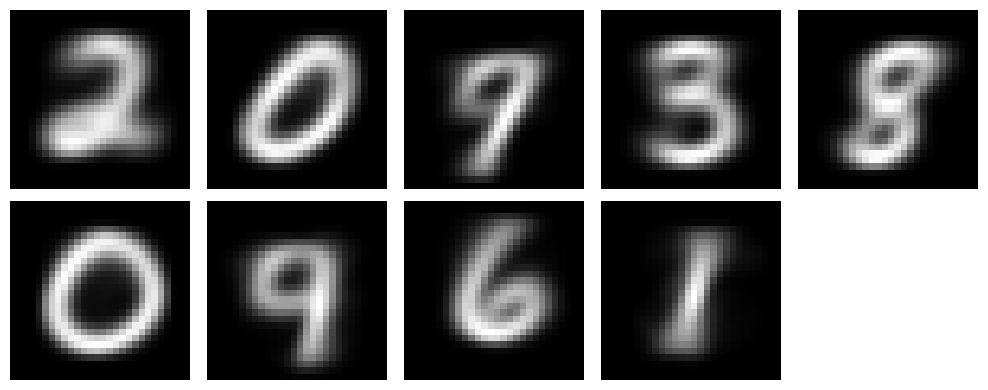

In [49]:
plot_centroids(clusters)